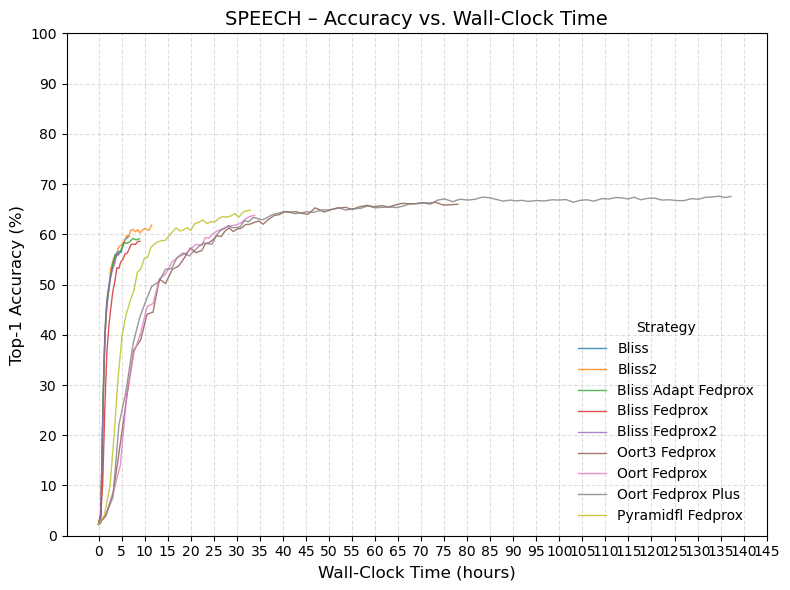

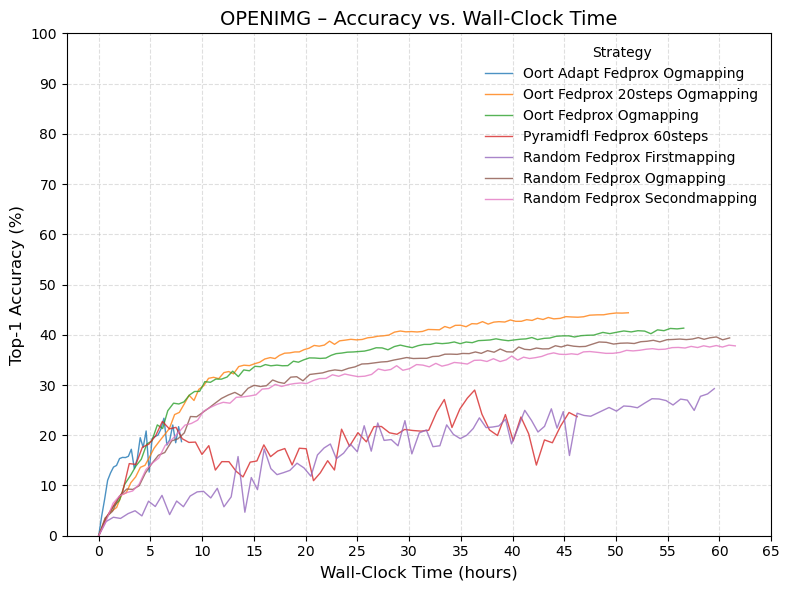

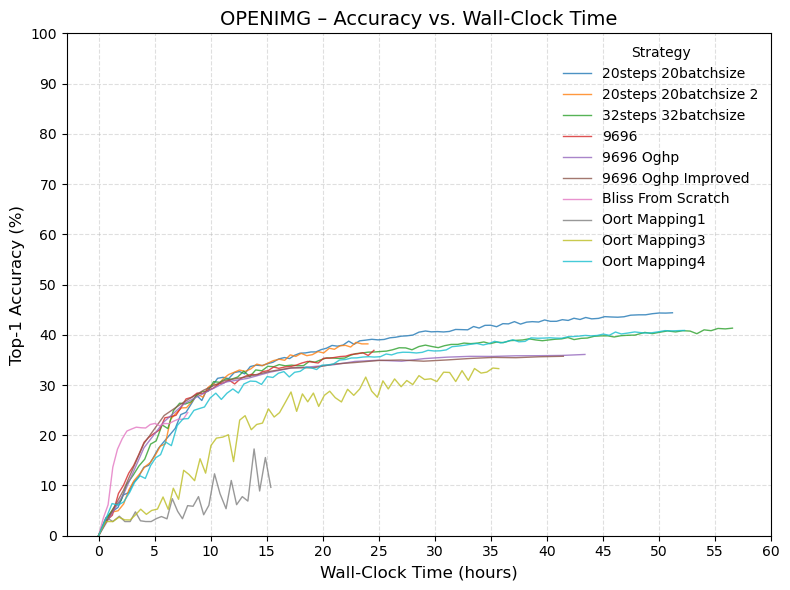

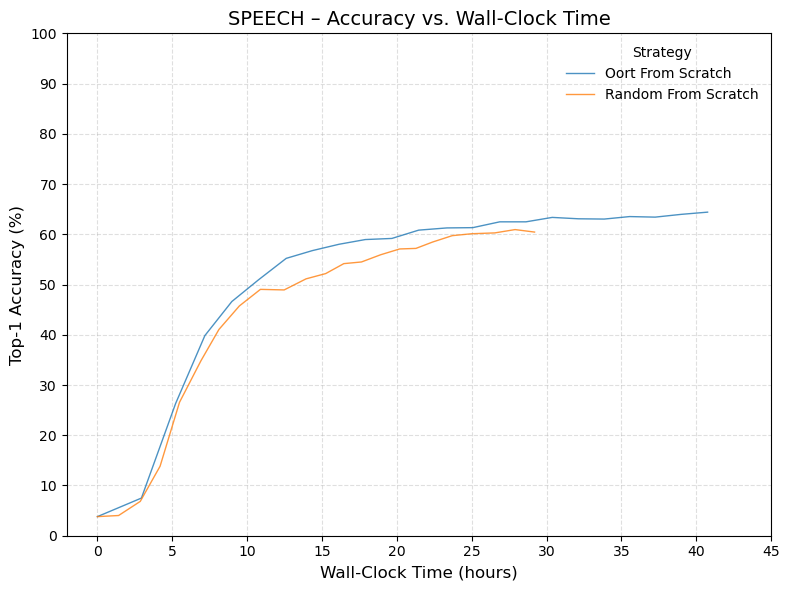

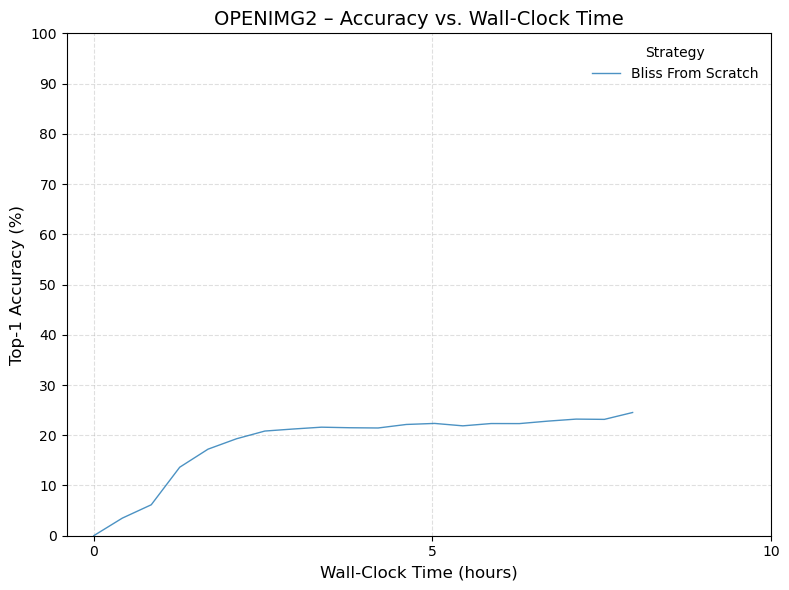

In [3]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt

def parse_log(filepath):
    """
    Parse a single log file, extracting wall-clock times (seconds) and top-1 accuracies.
    Returns two lists: times_hours, accuracies_percent.
    """
    clock_vals = []
    acc_vals = []
    pattern = re.compile(r"results: \{[^}]*'clock':\s*([\d\.]+),\s*'top_1':\s*([\d\.]+)")
    with open(filepath, 'r') as f:
        for line in f:
            m = pattern.search(line)
            if m:
                clock_s = float(m.group(1))
                top1    = float(m.group(2))
                clock_vals.append(clock_s / 3600.0)
                acc_vals.append(top1 * 100.0)
    times, accs = zip(*sorted(zip(clock_vals, acc_vals)))
    return np.array(times), np.array(accs)


def plot_task(task_name, base_path='../run_global_loggings/'):
    """
    For a given task ('openImg' or 'speech'), read all strategy logs
    and plot Accuracy vs. Wall-Clock Time with lines only.
    """
    task_dir = os.path.join(base_path, task_name)
    strategies = sorted([
        fn for fn in os.listdir(task_dir)
        if os.path.isfile(os.path.join(task_dir, fn))
    ])
    
    plt.figure(figsize=(8, 6))
    plt.grid(True, linestyle='--', alpha=0.4)
    
    for strat in strategies:
        logfile = os.path.join(task_dir, strat)
        times, accs = parse_log(logfile)

        # prettify the filename for the legend:
        pretty = " ".join(word.capitalize() for word in strat.split('_'))

        plt.plot(
            times, accs,
            linestyle='-',
            linewidth=1.0,
            alpha=0.8,
            label=pretty
        )

    
    # labels and title
    plt.xlabel('Wall‑Clock Time (hours)', fontsize=12)
    plt.ylabel('Top‑1 Accuracy (%)', fontsize=12)
    plt.title(f'{task_name.upper()} – Accuracy vs. Wall‑Clock Time', fontsize=14)
    
    # x-axis ticks every 5 hours
    max_hr = plt.xlim()[1]
    plt.xticks(np.arange(0, max_hr + 5, 5))
    
    # y-axis 0–100 with ticks every 10
    plt.ylim(0, 100)
    plt.yticks(np.arange(0, 101, 10))
    
    plt.legend(title='Strategy', fontsize=10, frameon=False)
    plt.tight_layout()
    plt.show()


# === Generate the two plots ===

# Speech
plot_task('speech')

plot_task('openImg')

plot_task('OpenImg')

plot_task('Speech')

plot_task('openImg2')

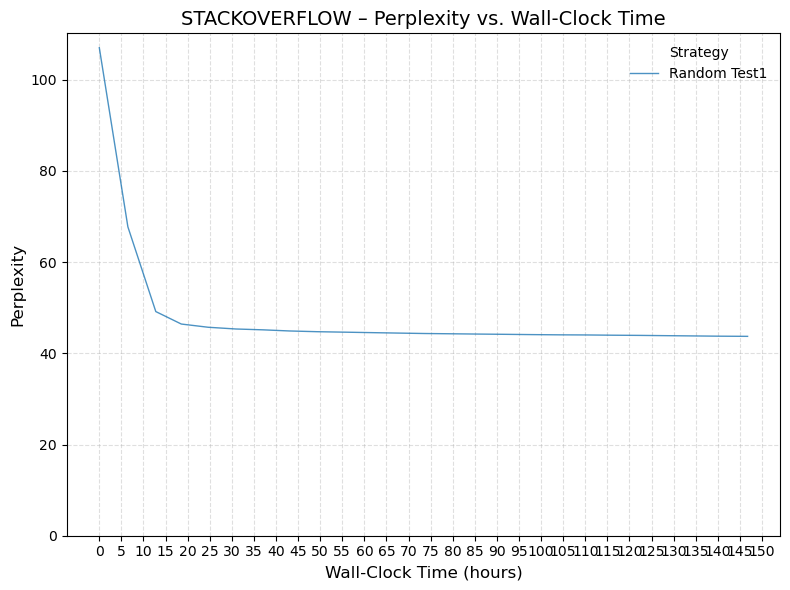

In [2]:
import os
import re
import math
import numpy as np
import matplotlib.pyplot as plt

def parse_stackoverflow_log(filepath):
    """Extract wall-clock hours and perplexity values from a StackOverflow log."""
    clock_vals = []
    perplexities = []
    clock_pattern = re.compile(r"""["']clock["']\s*:\s*([-+]?\d*.?\d+(?:[eE][-+]?\d+)?)""")
    loss_pattern = re.compile(r"""["']loss["']\s*:\s*([-+]?\d*.?\d+(?:[eE][-+]?\d+)?)""")
    

    with open(filepath, 'r', encoding='utf-8', errors='ignore') as f:
        for line in f:
            clock_match = clock_pattern.search(line)
            loss_match = loss_pattern.search(line)
            if clock_match and loss_match:
                clock_s = float(clock_match.group(1))
                loss_val = float(loss_match.group(1))
                clock_vals.append(clock_s / 3600.0)
                perplexities.append(loss_val**2)

    if not clock_vals:
        return np.array([]), np.array([])

    times, perps = zip(*sorted(zip(clock_vals, perplexities)))
    return np.array(times), np.array(perps)


def plot_stackoverflow(task_folder, base_path='../run_global_loggings/'):
    """Plot perplexity vs. wall-clock time for all StackOverflow experiments."""
    task_dir = os.path.join(base_path, task_folder)
    experiments = sorted([
        fn for fn in os.listdir(task_dir)
        if os.path.isfile(os.path.join(task_dir, fn))
    ])

    plt.figure(figsize=(8, 6))
    plt.grid(True, linestyle='--', alpha=0.4)

    max_hour = 0.0
    for exp in experiments:
        logfile = os.path.join(task_dir, exp)
        times, perps = parse_stackoverflow_log(logfile)
        if times.size == 0:
            continue

        pretty = " ".join(word.capitalize() for word in os.path.splitext(exp)[0].split('_'))

        plt.plot(
            times, perps,
            linestyle='-',
            linewidth=1.0,
            alpha=0.8,
            label=pretty
        )
        max_hour = max(max_hour, float(times.max()))

    plt.xlabel('Wall‑Clock Time (hours)', fontsize=12)
    plt.ylabel('Perplexity', fontsize=12)
    plt.title(f'{task_folder.upper()} – Perplexity vs. Wall‑Clock Time', fontsize=14)

    if max_hour > 0:
        plt.xticks(np.arange(0, max_hour + 5, 5))

    plt.ylim(bottom=0)
    plt.legend(title='Strategy', fontsize=10, frameon=False)
    plt.tight_layout()
    plt.show()


plot_stackoverflow('stackoverflow')

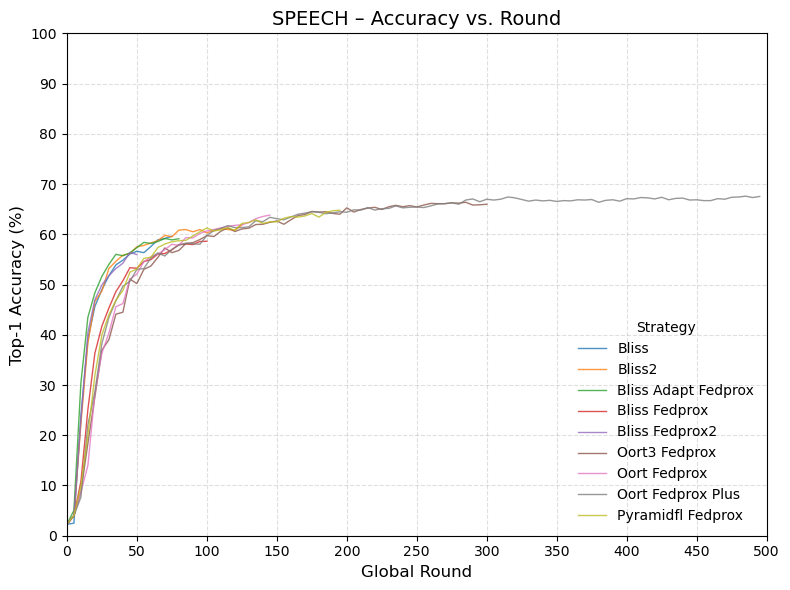

In [1]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt

def parse_log_by_round(filepath):
    """
    Parse a single log file, extracting round numbers and top-1 accuracies.
    Returns two lists: rounds_list, accuracies_percent.
    """
    round_vals = []
    acc_vals = []
    # regex to capture 'round' and 'top_1'
    pattern = re.compile(
        r"results: \{[^}]*'round':\s*(\d+),[^}]*'top_1':\s*([\d\.]+)"
    )
    with open(filepath, 'r') as f:
        for line in f:
            m = pattern.search(line)
            if m:
                rnd  = int(m.group(1))
                top1 = float(m.group(2))
                round_vals.append(rnd)
                acc_vals.append(top1 * 100.0)  # fraction → percent
    # sort by round in case logs are slightly out-of-order
    rounds_sorted, accs_sorted = zip(*sorted(zip(round_vals, acc_vals)))
    return np.array(rounds_sorted), np.array(accs_sorted)


def plot_accuracy_vs_round(task_name, base_path='../run_global_loggings/'):
    """
    For 'openImg' or 'speech', plot Top‑1 Accuracy (%) vs. Round Number.
    """
    task_dir = os.path.join(base_path, task_name)
    strategies = sorted([
        fn for fn in os.listdir(task_dir)
        if os.path.isfile(os.path.join(task_dir, fn))
    ])
    
    plt.figure(figsize=(8, 6))
    plt.grid(True, linestyle='--', alpha=0.4)
    
    for strat in strategies:
        logfile = os.path.join(task_dir, strat)
        times, accs = parse_log_by_round(logfile)

        # prettify the filename for the legend:
        pretty = " ".join(word.capitalize() for word in strat.split('_'))

        plt.plot(
            times, accs,
            linestyle='-',
            linewidth=1.0,
            alpha=0.8,
            label=pretty
        )
    
    # labels and title
    plt.xlabel('Global Round', fontsize=12)
    plt.ylabel('Top‑1 Accuracy (%)', fontsize=12)
    plt.title(f'{task_name.upper()} – Accuracy vs. Round', fontsize=14)
    
    # x-axis: 0–500 with ticks every 50 rounds
    plt.xlim(0, 500)
    plt.xticks(np.arange(0, 501, 50))
    
    # y-axis: 0–100 with ticks every 10
    plt.ylim(0, 100)
    plt.yticks(np.arange(0, 101, 10))
    
    plt.legend(title='Strategy', fontsize=10, frameon=False)
    plt.tight_layout()
    plt.show()


# === Generate the two plots ===

# Speech
plot_accuracy_vs_round('speech')



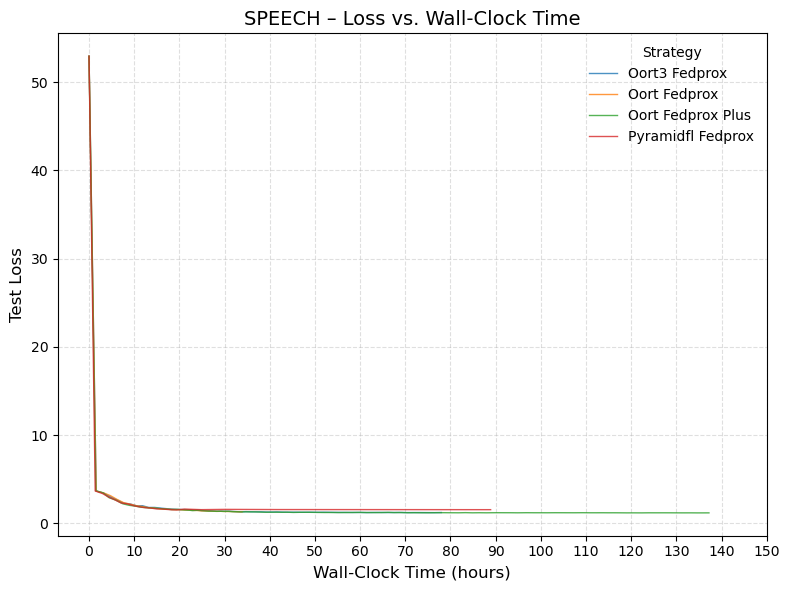

In [4]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt

def parse_log_loss(filepath):
    """
    Parse a single log file, extracting wall‑clock times (seconds) and losses.
    Returns two arrays: times_hours, loss_values.
    """
    clock_vals = []
    loss_vals = []
    pattern = re.compile(r"results: \{[^}]*'clock':\s*([\d\.]+),[^}]*'loss':\s*([\d\.]+)")
    with open(filepath, 'r') as f:
        for line in f:
            m = pattern.search(line)
            if m:
                clock_s = float(m.group(1))
                loss    = float(m.group(2))
                clock_vals.append(clock_s / 3600.0)  # seconds → hours
                loss_vals.append(loss)
    times, losses = zip(*sorted(zip(clock_vals, loss_vals)))
    return np.array(times), np.array(losses)


def plot_loss_vs_time(task_name, base_path='../run_global_loggings/'):
    """
    For 'openImg' or 'speech', plot Test Loss vs. Wall‑Clock Time
    using the same style as the loss‑vs‑round plots.
    """
    task_dir = os.path.join(base_path, task_name)
    strategies = sorted(
        fn for fn in os.listdir(task_dir)
        if os.path.isfile(os.path.join(task_dir, fn))
    )

    # figure setup
    plt.figure(figsize=(8, 6))
    plt.grid(True, linestyle='--', alpha=0.4)

    for strat in strategies:
        logfile = os.path.join(task_dir, strat)
        times, losses = parse_log_loss(logfile)

        # prettify the filename for the legend
        pretty = " ".join(w.capitalize() for w in strat.split('_'))

        plt.plot(
            times, losses,
            linestyle='-',
            linewidth=1.0,
            alpha=0.8,
            label=pretty
        )

    # labels and title
    plt.xlabel('Wall‑Clock Time (hours)', fontsize=12)
    plt.ylabel('Test Loss', fontsize=12)
    plt.title(f'{task_name.upper()} – Loss vs. Wall‑Clock Time', fontsize=14)

    # x‑axis ticks every 5 hours
    max_hr = plt.xlim()[1]
    plt.xticks(np.arange(0, max_hr + 10, 10))

    # legend and layout
    plt.legend(title='Strategy', fontsize=10, frameon=False)
    plt.tight_layout()
    plt.show()


# === Generate the two plots ===

# Speech
plot_loss_vs_time('speech')

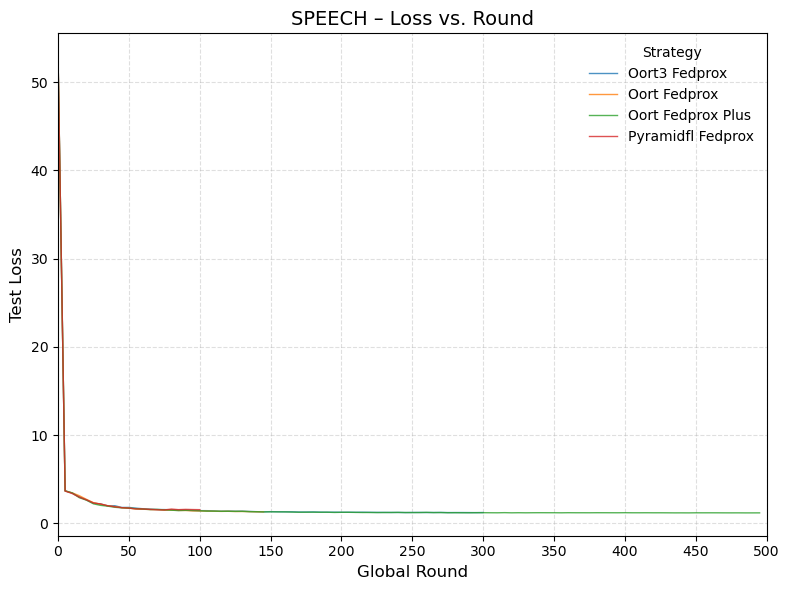

In [5]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt

def parse_log_loss_by_round(filepath):
    """
    Parse a single log file, extracting round numbers and loss values.
    Returns two arrays: rounds_list, loss_values.
    """
    round_vals = []
    loss_vals = []
    # regex to capture 'round' and 'loss'
    pattern = re.compile(
        r"results: \{[^}]*'round':\s*(\d+),[^}]*'loss':\s*([\d\.]+)"
    )
    with open(filepath, 'r') as f:
        for line in f:
            m = pattern.search(line)
            if m:
                rnd  = int(m.group(1))
                loss = float(m.group(2))
                round_vals.append(rnd)
                loss_vals.append(loss)
    # sort by round in case logs are slightly out-of-order
    rounds_sorted, losses_sorted = zip(*sorted(zip(round_vals, loss_vals)))
    return np.array(rounds_sorted), np.array(losses_sorted)


def plot_loss_vs_round(task_name, base_path='../run_global_loggings/'):
    """
    For 'openImg' or 'speech', plot Test Loss vs. Round Number.
    """
    task_dir = os.path.join(base_path, task_name)
    strategies = sorted([
        fn for fn in os.listdir(task_dir)
        if os.path.isfile(os.path.join(task_dir, fn))
    ])
    
    plt.figure(figsize=(8, 6))
    plt.grid(True, linestyle='--', alpha=0.4)
    
    for strat in strategies:
        logfile = os.path.join(task_dir, strat)
        times, accs = parse_log_loss_by_round(logfile)

        # prettify the filename for the legend:
        pretty = " ".join(word.capitalize() for word in strat.split('_'))

        plt.plot(
            times, accs,
            linestyle='-',
            linewidth=1.0,
            alpha=0.8,
            label=pretty
        )

    
    # labels and title
    plt.xlabel('Global Round', fontsize=12)
    plt.ylabel('Test Loss', fontsize=12)
    plt.title(f'{task_name.upper()} – Loss vs. Round', fontsize=14)
    
    # x-axis: 0–500 with ticks every 50 rounds
    plt.xlim(0, 500)
    plt.xticks(np.arange(0, 501, 50))
    
    # allow y-axis to auto-scale, but you can set limits manually if desired
    plt.legend(title='Strategy', fontsize=10, frameon=False)
    plt.tight_layout()
    plt.show()


# === Generate the two plots ===


# Speech
plot_loss_vs_round('speech')


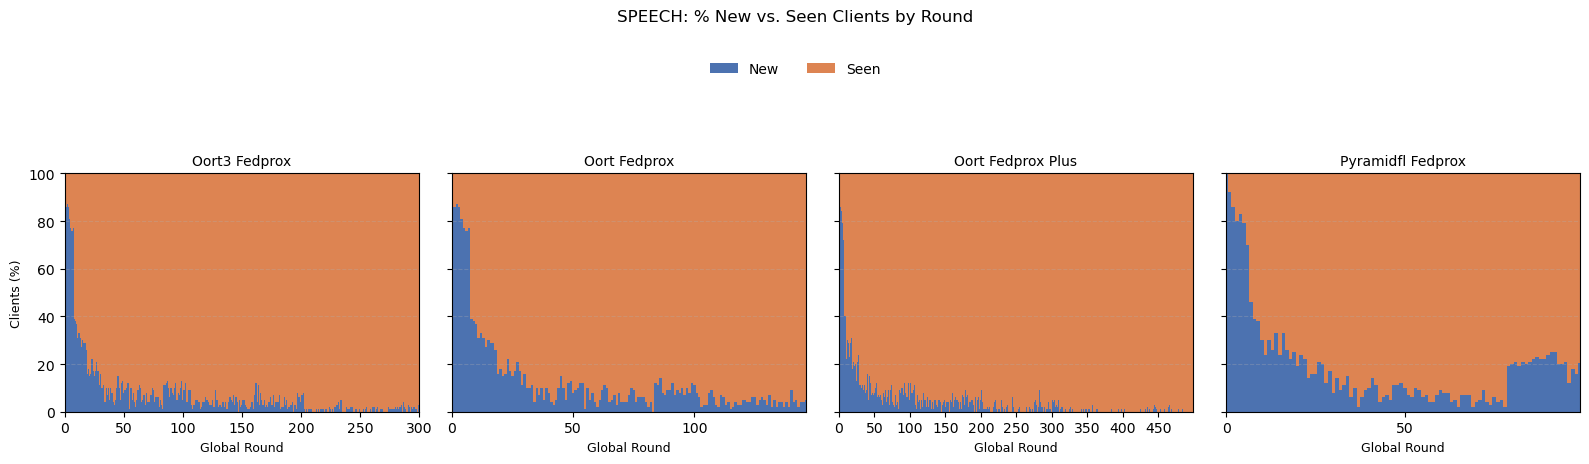

In [6]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt

def parse_selection(filepath):
    """
    Parse a log file for “Selected X participants to run: […]” lines.
    Returns two arrays (new_percent, seen_percent) per selection event.
    """
    seen_clients = set()
    new_percents = []
    seen_percents = []
    pattern = re.compile(r"Selected\s+(\d+)\s+participants to run:\s*\[([^\]]*)\]")
    with open(filepath, 'r') as f:
        for line in f:
            m = pattern.search(line)
            if not m:
                continue
            total = int(m.group(1))
            ids = [int(x) for x in m.group(2).split(',') if x.strip()]
            new_count = sum(1 for cid in ids if cid not in seen_clients)
            seen_count = total - new_count
            seen_clients.update(ids)
            new_percents.append(new_count / total * 100.0)
            seen_percents.append(seen_count / total * 100.0)
    return np.array(new_percents), np.array(seen_percents)

def plot_selection_by_round(task_name, base_path='../run_global_loggings/'):
    """
    For a given task ('openImg' or 'speech'), make a row of stacked‐bar
    plots (one per log file) showing % new vs. % seen clients, by round.
    """
    task_dir = os.path.join(base_path, task_name)
    logs = sorted([
        fn for fn in os.listdir(task_dir)
        if os.path.isfile(os.path.join(task_dir, fn))
    ])
    n = len(logs)
    fig, axes = plt.subplots(1, n, figsize=(4*n, 4), sharey=True)
    if n == 1:
        axes = [axes]

    # colors (you can tweak these)
    new_color  = '#4C72B0'   # blue
    seen_color = '#DD8452'   # orange

    for ax, logname in zip(axes, logs):
        fp = os.path.join(task_dir, logname)
        new_pct, seen_pct = parse_selection(fp)
        rounds = np.arange(len(new_pct))

        # wide bars to eliminate gaps, stacked
        ax.bar(rounds, new_pct,  width=1.0, color=new_color,  label='New')
        ax.bar(rounds, seen_pct, bottom=new_pct, width=1.0,
               color=seen_color, label='Seen')

        # title: make filename more readable
        title = logname.replace('_', ' ').replace('.tmp', '').title()
        ax.set_title(title, fontsize=10)
        ax.set_xlabel('Global Round', fontsize=9)
        ax.set_xticks(np.arange(0, len(rounds)+1, 50))
        ax.set_xlim(0, len(rounds)-1)
        if ax is axes[0]:
            ax.set_ylabel('Clients (%)', fontsize=9)
        # horizontal grid only
        ax.grid(axis='y', linestyle='--', alpha=0.3)

    # shared legend, placed above
    handles, labels = axes[-1].get_legend_handles_labels()
    fig.legend(
        handles, labels,
        loc='upper center', bbox_to_anchor=(0.5, 1.05),
        ncol=2, frameon=False, fontsize=10
    )
    fig.suptitle(f'{task_name.upper()}: % New vs. Seen Clients by Round',
                 fontsize=12, y=1.15)
    plt.tight_layout(rect=[0, 0, 1, 0.9])
    plt.show()

# === Usage ===
plot_selection_by_round('speech')


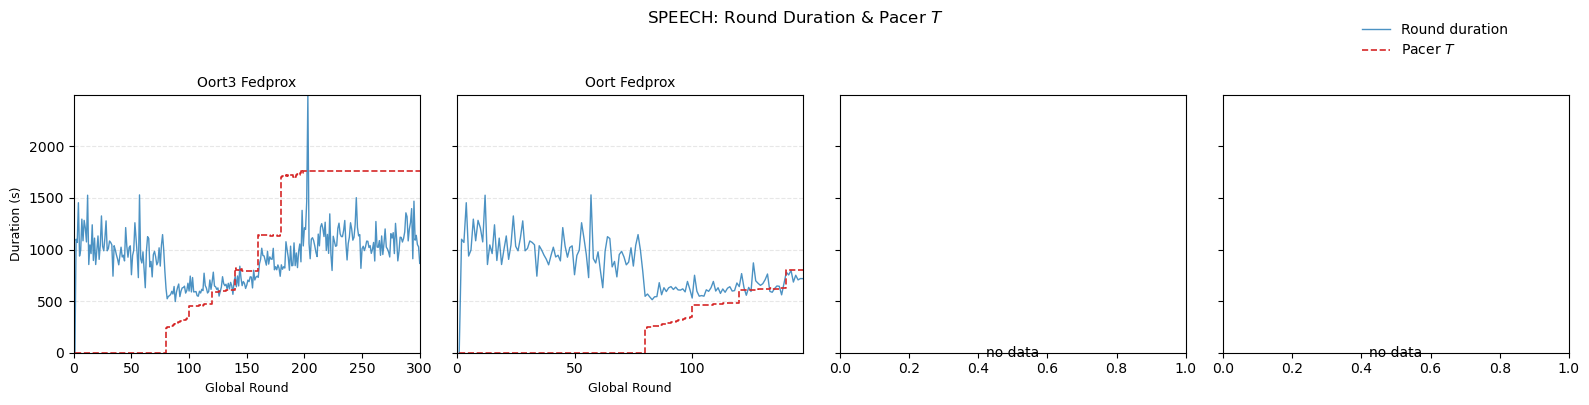

In [7]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt

def parse_rounds_and_pacers(filepath):
    """
    Parse a log file for:
      1) cumulative wall‑clock times per round
      2) pacer T values (preferred_duration) per round
    Returns:
      rounds: 1D numpy array of sorted round indices
      durations: 1D numpy array of per‑round durations (s)
      pacer_T: 1D numpy array of the same length, where pacer_T[i]
               is the T value active during round[i], or np.nan if none.
    """
    # patterns
    agg_re   = re.compile(r"Wall clock:\s*([\d\.]+)\s*s,\s*round:\s*(\d+)")
    oort_re  = re.compile(r"\[Oort\.Pacer\].*round=(\d+):\s*preferred_duration=([\d\.]+)s")
    bliss_re = re.compile(r"\[Bliss/Pacer\].*relaxing T to\s*([\d\.]+)\s*s")
    
    clocks = {}   # round -> cumulative clock
    pacers = {}   # round -> pacer T
    last_round = None
    
    with open(filepath, 'r') as f:
        for line in f:
            # aggregator line: update clocks and track last_round
            m = agg_re.search(line)
            if m:
                cum_time = float(m.group(1))
                rnd      = int(m.group(2))
                clocks[rnd] = cum_time
                last_round = rnd
                continue
            
            # Oort pacer line has explicit round
            m = oort_re.search(line)
            if m:
                pct_round = int(m.group(1))
                T = float(m.group(2))
                pacers[pct_round] = T
                continue
            
            # Bliss pacer line applies to last_round
            m = bliss_re.search(line)
            if m and last_round is not None:
                T = float(m.group(1))
                pacers[last_round] = T
                continue
    
    # sort rounds
    rounds_sorted = sorted(clocks.keys())
    if not rounds_sorted:
        return np.array([]), np.array([]), np.array([])
    
    cum_times = [clocks[r] for r in rounds_sorted]
    durations = [0.0] + [cum_times[i] - cum_times[i-1]
                         for i in range(1, len(cum_times))]

    # build pacer_T array by forward‐filling the last known T
    pacer_T = []
    last_T = np.nan
    for r in rounds_sorted:
        if r in pacers:
            last_T = pacers[r]
        pacer_T.append(last_T)
    
    return (np.array(rounds_sorted),
            np.array(durations),
            np.array(pacer_T))


def plot_round_durations_with_pacer(task_name, base_path='../run_global_loggings/'):
    """
    For a given task ('openImg' or 'speech'), create a row of line charts
    (one per log file) showing:
      • per-round duration (solid line)
      • pacer T (stairs, dashed)
    """
    task_dir = os.path.join(base_path, task_name)
    logs = sorted([
        fn for fn in os.listdir(task_dir)
        if os.path.isfile(os.path.join(task_dir, fn))
    ])
    n = len(logs)
    fig, axes = plt.subplots(1, n, figsize=(4*n, 4), sharey=True)
    if n == 1:
        axes = [axes]

    # first pass: parse all, find global max duration to align y‑axes
    data = {}
    max_dur = 0.0
    for name in logs:
        fp = os.path.join(task_dir, name)
        rounds, dur, T = parse_rounds_and_pacers(fp)
        data[name] = (rounds, dur, T)
        if dur.size and dur.max() > max_dur:
            max_dur = dur.max()

    for ax, name in zip(axes, logs):
        rounds, dur, T = data[name]
        if rounds.size == 0:
            ax.text(0.5, 0.5, 'no data', ha='center', va='center')
            continue

        # plot round durations
        ax.plot(
            rounds, dur,
            color='tab:blue', lw=1.0, alpha=0.8,
            label='Round duration'
        )

        # plot pacer T as a step function if any T is not nan
        if ('bliss_wo-adapt_fedprox' not in name) and (not np.all(np.isnan(T))):
            ax.step(
                rounds, T,
                where='post',
                color='tab:red', linestyle='--', lw=1.2,
                label='Pacer $T$'
            )

        # formatting
        title = name.replace('_', ' ').replace('.tmp', '').title()
        ax.set_title(title, fontsize=10)
        ax.set_xlabel('Global Round', fontsize=9)
        ax.set_xticks(np.arange(0, rounds.max()+50, 50))
        ax.set_xlim(0, rounds.max())
        if ax is axes[0]:
            ax.set_ylabel('Duration (s)', fontsize=9)
        ax.set_ylim(0, max_dur)
        ax.grid(axis='y', linestyle='--', alpha=0.3)

        # square aspect if desired:
        # ax.set_box_aspect(1)

    # gather unique handles & labels from all subplots
    all_handles = []
    all_labels = []
    for ax in axes:
        h, l = ax.get_legend_handles_labels()
        for hi, li in zip(h, l):
            if li not in all_labels:
                all_handles.append(hi)
                all_labels.append(li)

    fig.legend(
        all_handles, all_labels,
        loc='upper center',
        bbox_to_anchor=(0.9, 1),
        ncol=1,
        frameon=False,
        fontsize=10
    )

    fig.suptitle(f'{task_name.upper()}: Round Duration & Pacer $T$', fontsize=12, y=1)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


# === Usage ===
plot_round_durations_with_pacer('speech')

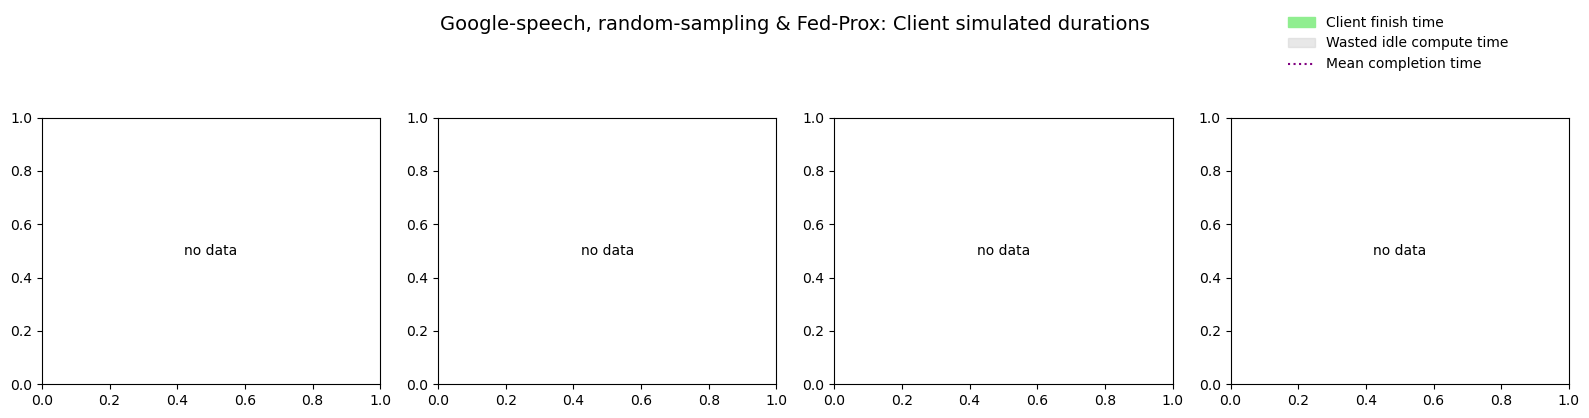

In [9]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

def parse_client_durations(filepath, target_rounds):
    """
    Walk the logfile, collect per-client simulated_duration for each completed round.
    Returns a dict: round -> sorted list of durations (seconds).
    """
    durations_by_round = {r: [] for r in target_rounds}
    cur_durs = []
    client_re = re.compile(r"client\s+\d+\s+finished, simulated_duration\s*=\s*([\d\.]+)\s*s")
    round_re  = re.compile(r"\*\*\*\s*ROUND\s+(\d+)\s+COMPLETE")
    
    with open(filepath, 'r') as f:
        for line in f:
            m_c = client_re.search(line)
            if m_c:
                cur_durs.append(float(m_c.group(1)))
                continue
            m_r = round_re.search(line)
            if m_r:
                rnd = int(m_r.group(1))
                if rnd in target_rounds:
                    durations_by_round[rnd] = sorted(cur_durs)
                cur_durs = []  # reset for next round
    return durations_by_round

# load the single log file
logfile = '../run_global_loggings/speech/pyramidfl_fedprox'
rounds_to_plot = [1, 6, 8, 10]
data = parse_client_durations(logfile, rounds_to_plot)

# prepare subplots: one square per round
n = len(rounds_to_plot)
fig, axes = plt.subplots(1, n, figsize=(4 * n, 4))
for ax, rnd in zip(axes, rounds_to_plot):
    durs = np.array(data[rnd])
    m = len(durs)
    if m == 0:
        ax.text(0.5, 0.5, 'no data', ha='center', va='center')
        continue

    # bar chart
    x = np.arange(m)
    ax.bar(x, durs, color='lightgreen', width=1.0)

    # shade idle triangle
    max_d = durs[-1]
    ax.fill_between(
        x, durs, max_d,
        step='post', color='lightgray', alpha=0.5
    )

    # mean line
    mean_d = durs.mean()
    ax.hlines(
        mean_d, xmin=0, xmax=m-1,
        colors='purple', linestyles=':', linewidth=1.5
    )

    # one x‑tick centered
    ax.set_xticks([m // 2])
    ax.set_xticklabels(['Client'])
    ax.set_xlabel('')

    # y‑ticks: 10 bins, formatted mm:ss
    yticks = np.linspace(0, max_d, 11)
    ylabels = [f"{int(t//60)}:{int(t%60):02d}" for t in yticks]
    ax.set_yticks(yticks)
    ax.set_yticklabels(ylabels)
    ax.set_ylabel('Duration (mm:ss)')

    ax.set_title(f'Round {rnd}', fontsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.3)

    # make each subplot square
    ax.set_box_aspect(1)

# shared legend and title, placed above the row
handles = [
    Patch(color='lightgreen', label='Client finish time'),
    Patch(color='lightgray', alpha=0.5, label='Wasted idle compute time'),
    plt.Line2D([0], [0], color='purple', linestyle=':', label='Mean completion time')
]
fig.legend(
    handles, [h.get_label() for h in handles],
    loc='upper left',
    bbox_to_anchor=(0.8, 1.05),
    ncol=1,
    frameon=False,
    fontsize=10
)

fig.suptitle('Google-speech, random-sampling & Fed-Prox: Client simulated durations', fontsize=14, y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()


In [10]:
import os
import re

def analyze_top1(task_name, threshold, base_path='../run_global_loggings'):
    """
    For each log in the given task folder, print:
      • prettified log name
      • first round where top_1 >= threshold (or None if never reached)
      • virtual_clock at that round, as an integer number of seconds
      • maximum top_1 value observed
    """
    task_dir = os.path.join(base_path, task_name)
    # Regex captures round number, virtual_clock, and top_1 value
    pattern = re.compile(
        r"FL Testing in round:\s*(\d+),\s*virtual_clock:\s*([\d\.]+),.*?'top_1':\s*([\d\.]+)"
    )
    
    for fname in sorted(os.listdir(task_dir)):
        fp = os.path.join(task_dir, fname)
        if not os.path.isfile(fp):
            continue
        
        rounds = []
        clocks = []
        top1s  = []
        with open(fp, 'r') as f:
            for line in f:
                m = pattern.search(line)
                if m:
                    rounds.append(int(m.group(1)))
                    clocks.append(float(m.group(2)))
                    top1s.append(float(m.group(3)))
        
        if not top1s:
            continue
        
        # Find first index meeting threshold
        idx = next((i for i, t in enumerate(top1s) if t >= threshold), None)
        if idx is not None:
            first_round = rounds[idx]
            first_clk   = int(clocks[idx])  # integer seconds
        else:
            first_round = None
            first_clk   = None
        
        max_top1 = max(top1s)
        
        # Prettify filename
        pretty_name = " ".join(word.capitalize() for word in fname.split('_'))
        
        # Print results
        print(f"{pretty_name}:")
        print(f"  • First round ≥ {threshold} → {first_round}", end='')
        if first_clk is not None:
            print(f", virtual_clock = {first_clk} s")
        else:
            print()
        print(f"  • Max top_1 = {max_top1:.4f}\n")

# === Run analysis ===

# Speech: threshold 0.622
analyze_top1('speech', 0.622)

Oort3 Fedprox:
  • First round ≥ 0.622 → 145, virtual_clock = 121824 s
  • Max top_1 = 0.6637

Oort Fedprox:
  • First round ≥ 0.622 → 130, virtual_clock = 111697 s
  • Max top_1 = 0.6382

Oort Fedprox Plus:
  • First round ≥ 0.622 → 135, virtual_clock = 113950 s
  • Max top_1 = 0.6759

Pyramidfl Fedprox:
  • First round ≥ 0.622 → None
  • Max top_1 = 0.5745



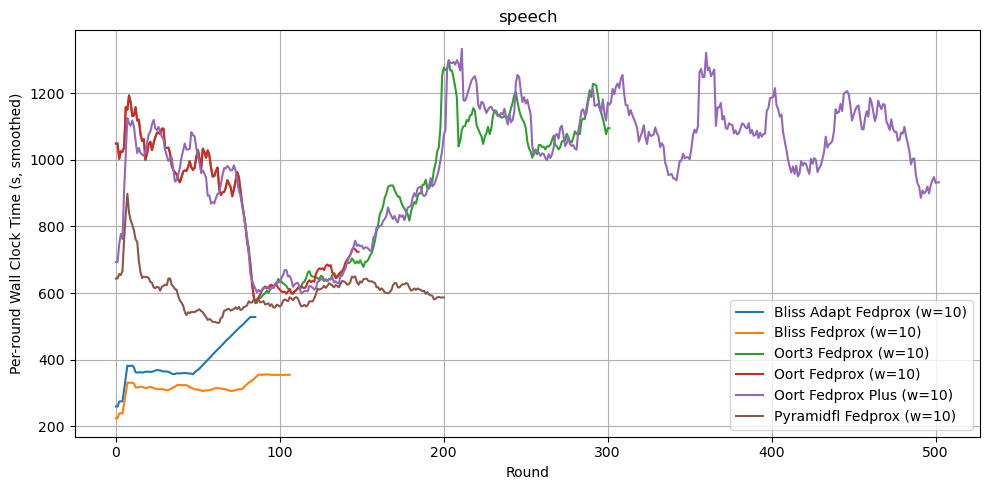

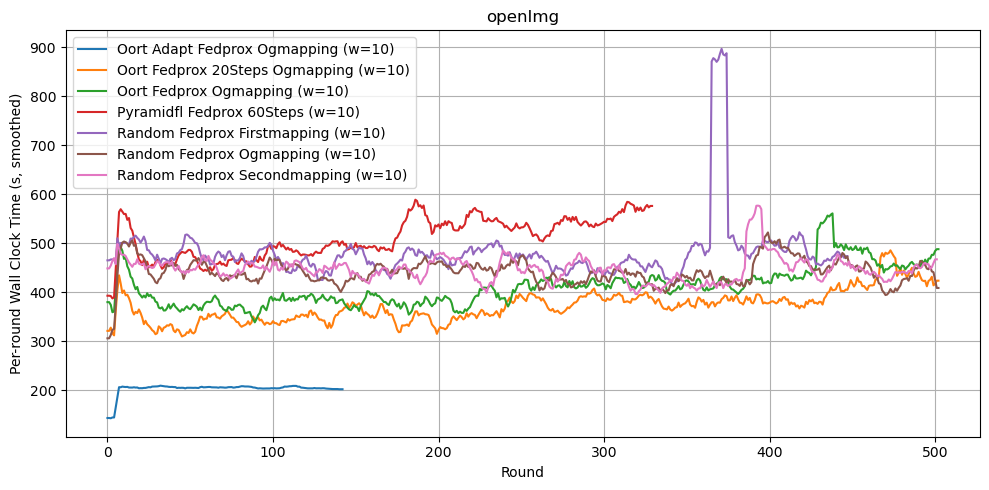

In [5]:
# Notebook cell: plot per-round (non-cumulative) wall clock times, smoothed over 10 rounds
import re
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

def _moving_avg_centered(x, window=10):
    if window <= 1 or len(x) == 0:
        return x
    k = window
    pad = k // 2
    # reflect-pad to keep same length
    x_pad = np.pad(np.asarray(x, dtype=float), (pad, pad), mode='reflect')
    kernel = np.ones(k, dtype=float) / k
    y = np.convolve(x_pad, kernel, mode='valid')
    # if window is even, 'centered' is slightly right-shifted; still fine for smoothing
    return y

def plot_wall_clock_vs_round(folder_path, recursive=False, save_plots=False, smooth_window=10):
    folder = Path(folder_path)
    files = list(folder.rglob('*') if recursive else folder.iterdir())
    files = [f for f in files if f.is_file()]  # include all files
    
    # Matches lines like: "Wall clock time: 123.45"
    pattern = re.compile(r'Wall clock time:\s*([0-9]+(?:\.[0-9]+)?)', re.IGNORECASE)
    
    plt.figure(figsize=(10, 5))
    parent_name = folder.resolve().name
    plotted_any = False
    
    for f in sorted(files):
        with open(f, 'r', encoding='utf-8', errors='ignore') as fh:
            clocks = [float(m.group(1)) for line in fh if (m := pattern.search(line))]
        if not clocks:
            continue

        # cumulative -> per-round durations
        per_round = []
        prev = None
        for val in clocks:
            if prev is None:
                per_round.append(val)
            else:
                diff = val - prev
                per_round.append(diff if diff >= 0 else val)  # handle rare resets
            prev = val

        # smooth across 10 rounds (centered MA)
        per_round_sm = _moving_avg_centered(per_round, window=smooth_window)

        rounds = list(range(len(per_round_sm)))
        label = f.stem.replace('_', ' ').title() + f" (w={smooth_window})"
        plt.plot(rounds, per_round_sm, label=label)
        plotted_any = True

    if not plotted_any:
        print("No matching 'Wall clock time' lines found in folder.")
        return
    
    plt.xlabel("Round")
    plt.ylabel("Per-round Wall Clock Time (s, smoothed)")
    plt.title(parent_name)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    
    if save_plots:
        out_path = folder / f"{parent_name}_wall_clock_per_round_smoothed_w{smooth_window}.png"
        plt.savefig(out_path, bbox_inches="tight")
        print(f"Saved plot to {out_path}")
        plt.close()
    else:
        plt.show()
        plt.close()

# Example
plot_wall_clock_vs_round('../run_global_loggings/speech', recursive=False, save_plots=False, smooth_window=10)


plot_wall_clock_vs_round('../run_global_loggings/openImg', recursive=False, save_plots=False)

In [3]:
import numpy as np

def symmetric_difference_arrays(a, b):
    """
    Prints a tuple of arrays:
      (elements in a not in b, elements in b not in a)
    """
    a_not_in_b = np.setdiff1d(a, b)
    b_not_in_a = np.setdiff1d(b, a)
    print(a_not_in_b)
    print(b_not_in_a)


a = np.array([748, 1756, 2143, 866, 1777, 2028, 1028, 1642, 795, 1725, 2199, 2338, 664, 1485, 516, 1506, 1447, 1713, 1927, 1099, 1595, 2393, 644, 1090, 2201, 2170, 519, 647, 1541, 628, 2049, 136, 1668, 1669, 1407, 604, 497, 1294, 2592, 1563, 2518, 620, 119, 2120, 2466, 2500, 2610, 2402, 163, 1399, 479, 131, 2131, 2486, 642, 1548, 1557, 115, 1540, 494, 1481, 1525, 1244, 2379, 1395, 897, 177, 2576, 1727, 496, 1840, 148, 787, 2339, 1068, 1001, 141, 1349, 1372, 111, 1954, 2522, 698, 1241, 167, 1043, 109, 1336, 2112, 490, 1354, 151, 168, 1861, 1023, 1416, 173, 1391, 380, 688])
b = np.array([748, 1756, 2143, 866, 1777, 2028, 1028, 1642, 795, 1725, 2199, 2338, 664, 516, 1594, 1447, 1713, 1595, 2393, 644, 1090, 2170, 519, 647, 1541, 628, 2049, 136, 1668, 1669, 1407, 604, 497, 1294, 2592, 1563, 2518, 620, 119, 2120, 2466, 514, 2500, 2610, 2402, 163, 1399, 479, 131, 2131, 1690, 2486, 1548, 1557, 2429, 115, 1540, 1652, 494, 1805, 1481, 1525, 1244, 2379, 1395, 897, 177, 2588, 893, 496, 1840, 148, 787, 2339, 1068, 1001, 141, 1349, 1372, 1954, 2522, 731, 698, 1241, 167, 109, 2112, 490, 500, 1354, 151, 168, 2434, 1023, 1416, 173, 135, 380, 2197, 688])

symmetric_difference_arrays(a, b)

[ 111  642 1043 1099 1336 1391 1485 1506 1727 1861 1927 2201 2576]
[ 135  500  514  731  893 1594 1652 1690 1805 2197 2429 2434 2588]
